In [81]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision import utils, transforms
from extras.encoder import ResnetEncoder
import torch.nn.functional as F
from extras.anchors import get_offsets
from extras.boxes import box_iou, nms
from extras.util import *

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [83]:
COCO_DIR = "train2014"
SYNTHETIC_DIR = "coco_synthetic"

In [84]:
train_file_info_frame = pd.read_csv('train_filter.txt', delimiter=" ", header=None)
train_file_info_frame

,0,1,2,3,4,5
0,Tp_75466_471421_31.84_62.29_640.0_251.24_airpl...,11.8400,66.35659,640.0000,368.3100,tamper
1,COCO_train2014_000000075466.jpg,11.8400,42.29000,660.0000,271.2400,authentic
2,Tp_354517_564330_393.81_312.08_640.0_422.7_bed...,275.3575,447.75460,480.0000,640.0000,tamper
3,COCO_train2014_000000354517.jpg,373.8100,292.08000,660.0000,442.7000,authentic
4,Tp_251466_448046_38.24_19.17_219.78_317.53_per...,9.8750,0.00000,191.7031,268.0703,tamper
...,...,...,...,...,...,...
21517,COCO_train2014_000000110230.jpg,110.5500,144.04000,349.8100,274.2300,authentic
21518,Tp_39138_135332_149.93_12.94_267.51_125.12_ref...,129.9300,0.00000,287.5100,144.3380,tamper
21519,COCO_train2014_000000039138.jpg,129.9300,0.00000,287.5100,145.1200,authentic
21520,Tp_22726_506843_1.01_123.64_640.0_400.33_airpl...,0.0000,60.59902,640.0000,280.9690,tamper


In [87]:
test_file_info_frame = pd.read_csv(
    'test_filter.txt', delimiter=" ", header=None)
test_file_info_frame


,0,1,2,3,4,5
0,Tp_513867_476061_362.16_302.48_418.79_343.21_p...,342.16000,274.50390,438.7900,354.1598,tamper
1,COCO_train2014_000000513867.jpg,342.16000,282.48000,438.7900,363.2100,authentic
2,Tp_88719_197636_462.5_162.16_594.92_420.28_per...,442.50000,142.16000,614.9200,427.0000,tamper
3,COCO_train2014_000000088719.jpg,442.50000,142.16000,614.9200,440.2800,authentic
4,Tp_319765_216279_1.43_14.35_444.84_374.53_pers...,0.00000,0.00000,613.1200,299.7271,tamper
...,...,...,...,...,...,...
2139,COCO_train2014_000000028764.jpg,89.82000,223.22000,149.3600,323.3700,authentic
2140,Tp_353589_167910_76.15_107.57_268.0_601.8_pers...,33.89992,83.95565,209.6937,601.5795,tamper
2141,COCO_train2014_000000353589.jpg,56.15000,87.57000,288.0000,621.8000,authentic
2142,Tp_15816_320271_150.65_90.04_388.62_341.44_per...,130.65000,81.21593,408.6200,403.8201,tamper


In [85]:
def get_image(filename):
    imdir = SYNTHETIC_DIR if filename[:2] == "Tp" else COCO_DIR
    return io.imread(os.path.join(imdir, filename))

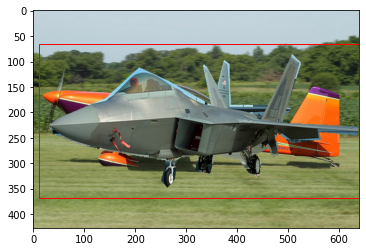

In [86]:
def show_bbox(image, box):
    """Show image with landmarks"""
    plt.imshow(image)
    draw_box(plt.gca(), box)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure()
show_bbox(get_image(file_info_frame.iloc[0, 0]),
               file_info_frame.iloc[0, 1:5].values)
plt.show()

In [40]:
class ImageManipDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, txt_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file_info_frame = pd.read_csv(txt_file, delimiter=" ", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.file_info_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = get_image(self.file_info_frame.iloc[idx, 0])
        bbox = self.file_info_frame.iloc[idx, 1:5].values
        is_authentic = 1 if file_info_frame.iloc[idx, 5] == "authentic" else 0
        sample = {'image': image, 'bbox': bbox}

        if self.transform:
            sample = self.transform(sample)
        
        sample["authentic"] = is_authentic

        return sample


In [41]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bbox = np.array(bbox * [new_w / w, new_h / h, new_w / w, new_h / h]).astype(float)

        return {'image': img, 'bbox': bbox}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'bbox': torch.from_numpy(bbox)}


In [42]:
coco_transform = transforms.Compose([
    Rescale((128, 128)),
    ToTensor()
])


In [43]:
transformed_dataset = ImageManipDataset(txt_file='train_filter.txt',
                                        transform=coco_transform)


In [44]:
train_loader = DataLoader(transformed_dataset, batch_size=64, shuffle=True)

In [45]:
def get_gt_boxes():
    """
    Generate 192 boxes where each box is represented by :
    [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    Each anchor position should generate 3 boxes according to the scales and ratios given.

    Return this result as a numpy array of size [192,4]
    """
    stride = 16 # The stride of the final feature map is 16 (the model compresses the image from 128 x 128 to 8 x 8)
    map_sz = 128 # this is the length of height/width of the image

    scales = torch.tensor([40,50,60])
    ratios = torch.tensor([[1,1]]).view(1,2)
    
    half_stride = int(stride / 2)
    num_grids = int((map_sz / stride) ** 2)
    num_boxes = int(num_grids * scales.shape[0])
    boxes_size = ratios.T * scales
    gt_boxes = torch.zeros((num_boxes, 4))

    for i in range(num_boxes):
        grid_index = i // scales.shape[0]
        box_index = i % scales.shape[0]
        center_x = int(grid_index % (map_sz / stride) * stride + half_stride)
        center_y = int(grid_index // (map_sz / stride) * stride + half_stride)
        top_left_x = center_x - (boxes_size[0, box_index] / 2)
        top_left_y = center_y - (boxes_size[1, box_index] / 2)
        bottom_right_x = center_x + (boxes_size[0, box_index] / 2)
        bottom_right_y = center_y + (boxes_size[1, box_index] / 2)
        gt_boxes[i, :] = torch.tensor([top_left_x, top_left_y, 
                                       bottom_right_x, bottom_right_y])



    return gt_boxes

gt_boxes = get_gt_boxes()

In [69]:
class ManipDetectionModel(nn.Module):

    def __init__(self):
        super(ManipDetectionModel, self).__init__()

        # for each grid in the feature map we have 3 anchors of sizes: 40x40, 50x50, 60x60
        num_anchors = 3

        # regular resnet 18 encoder
        self.encoder = ResnetEncoder(num_layers=18, pretrained=True)

        # a small conv net
        self.conv = nn.Conv2d(
            256, 256, kernel_size=3, stride=1, padding=1
        )

        # Add a Convolutional Layer to prediction the class predictions. This is a head that predicts whether a chunk/anchor contains an object or not.
        self.cls_logits = nn.Sequential(
            nn.Conv2d(256, num_anchors, kernel_size=3, padding=1), nn.Sigmoid())

        # Add a Convolutional Layer to prediction the class predictions. This is a head that regresses over the 4 bounding box offsets for each anchor
        self.bbox_pred = nn.Conv2d(
            256, num_anchors * 4, kernel_size=3, padding=1)

    def permute_and_flatten(self, layer, N, A, C, H, W):
        # helper function that rearranges the input for the loss function
        layer = layer.view(N, -1, C, H, W)
        layer = layer.permute(0, 3, 4, 1, 2)
        layer = layer.reshape(N, -1, C)
        return layer

    def get_predict_regressions(self, cls_pred, box_pred):
        # helper function that gets outputs in the right shape for applying the loss
        N, AxC, H, W = cls_pred.shape
        Ax4 = box_pred.shape[1]
        A = Ax4 // 4
        C = AxC // A
        cls_pred = self.permute_and_flatten(
            cls_pred, N, A, C, H, W
        )

        auth_pred = self.permute_and_flatten(
            cls_pred, N, A, C, H, W
        )

        box_pred = self.permute_and_flatten(
            box_pred, N, A, 4, H, W
        )
        return cls_pred, box_pred

    def forward(self, x):
        bt_sz = x.size(0)

        # we take the 3rd output feature map of size 8 x 8 from
        # the resnet18 encoder this means that the stride
        # is 16 as our input image is 128x128 in size.
        x = self.encoder(x)[3]

        x = F.relu(self.conv(x))

        cls_pred = self.cls_logits(x)
        box_pred = self.bbox_pred(x)

        cls_pred, box_pred = self.get_predict_regressions(cls_pred, box_pred)

        return cls_pred.squeeze(2), box_pred


In [62]:
def get_bbox_gt(ex_boxes, gt_boxes, is_auth, sz=128):
    '''

    INPUT:
    ex_boxes: [Nx4]: Bounding boxes in the image. Here N is the number of bounding boxes the image has
    gt_boxes: [192 x 4]: Anchor boxes of an image of size 128 x 128 with stride 16.
    sz : 128
    OUTPUT:
    gt_classes: [192 x 1] : Class labels for each anchor: 1 is for foreground, 0 is for background and -1 is for a bad anchor. [where IOU is between 0.3 and 0.7]
    gt_offsets: [192 x 4]: Offsets for anchor to best fit the bounding box object. 0 values for 0 and -1 class anchors.

    '''
    high_threshold = 0.7
    low_threshold = 0.3

    iou, ex_index = box_iou(gt_boxes, ex_boxes).max(
        dim=1)  # max iou and the index of bounding box
    # nearest bounding box to each anchor box
    crsp_ex_boxes = ex_boxes[ex_index, :]

    gt_classes = -1 * torch.ones(192, 1)
    gt_classes[iou > high_threshold] = 2 if is_auth else 1
    gt_classes[iou < low_threshold] = 1

    gt_offsets = get_offsets(gt_boxes, crsp_ex_boxes)
    no_object = ((gt_classes == 0) | (gt_classes == -1)
                 ).nonzero(as_tuple=True)[0]
    gt_offsets[no_object, :] = torch.zeros(1, 4)
    return gt_classes, gt_offsets


def get_targets(sample, target, is_auth):
    '''
    Input
    target => Set of bounding boxes for each image.
    Sample => Each image
    Output:
    Bounding box offsets and class labels for each anchor.
    '''

    batched_preds = []
    batched_offsets = []
    final_cls_targets = []
    final_box_offsets = []
    for s, t, a in zip(sample, target, is_auth):
        bboxes = t.float().reshape(1, -1)
        class_targets, box_offsets = get_bbox_gt(bboxes, gt_boxes, a, sz=128)
        final_cls_targets.append(class_targets)
        final_box_offsets.append(box_offsets)

    final_cls_targets = torch.stack(final_cls_targets, dim=0)
    final_box_offsets = torch.stack(final_box_offsets, dim=0)

    return final_cls_targets, final_box_offsets


In [63]:
def class_loss(out_pred, class_targets, device="cuda"):
    # return class loss
    class_targets_copy = class_targets.to(device)
    criterion = nn.CrossEntropyLoss()
    class_targets_copy = class_targets_copy.squeeze()
    out_pred[class_targets_copy < 0] = 0
    class_targets_copy[class_targets_copy < 0] = 0
    return criterion(out_pred, class_targets_copy)


def bbox_loss(out_bbox, box_targets, class_targets, device='cuda'):
    # return bounding box offset loss
    box_targets = box_targets.to(device)
    class_targets_copy = class_targets.to(device)
    criterion = nn.L1Loss()
    class_targets_copy = class_targets_copy.repeat(1, 1, 4)

    out_bbox[class_targets_copy != 1] = 0
    box_targets[class_targets_copy != 1] = 0
    return criterion(out_bbox, box_targets)


In [80]:
# Training Function.
def train(ep, model, trainloader, optimizer):
    total_loss = 0
    b_loss = 0
    c_loss = 0
    with tqdm(trainloader) as tepoch:
        for data_dict in tepoch:
            ims = data_dict["image"].float().to(device)
            class_targets, box_targets = get_targets(data_dict["image"], data_dict["bbox"], data_dict["authentic"])
            out_pred, out_box = model(ims)
            loss_cls = class_loss(out_pred, class_targets, device)
            loss_bbox = bbox_loss(out_box, box_targets, class_targets, device)
            loss = loss_cls + loss_bbox

            if loss.item() != 0:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            c_loss += loss_cls.item()
            b_loss += loss_bbox.item()

    avg_c_loss = float(c_loss / len(trainloader))
    avg_b_loss = float(b_loss / len(trainloader))

    print('Trained Epoch: {} | Avg Classification Loss: {}, Bounding loss: {}\n'.format(
        ep, avg_c_loss, avg_b_loss))


model = ManipDetectionModel().to(device)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1, momentum=0.9, weight_decay=1e-4)
for ep in range(5):
    train(ep, model, train_loader, optimizer)

torch.save(model.state_dict(), 'model.pth')


  6%|▌         | 20/337 [02:23<37:55,  7.18s/it]


KeyboardInterrupt: 

In [53]:
a, b ,c = iter(train_loader).next()

In [56]:
type(iter(train_loader).next())


dict